In [ ]:
import csv
import math

def angle_between_points(p1, p2):
    """Oblicz kąt linii p1->p2 względem osi poziomej (podłoża), w stopniach."""
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    angle = math.degrees(math.atan2(dy, dx))
    return angle

def angle_between_vectors(v1, v2):
    """Oblicz kąt między dwoma wektorami w stopniach."""
    dot = v1[0]*v2[0] + v1[1]*v2[1]
    mag1 = math.sqrt(v1[0]**2 + v1[1]**2)
    mag2 = math.sqrt(v2[0]**2 + v2[1]**2)
    if mag1 == 0 or mag2 == 0:
        return 0
    cos_angle = dot / (mag1 * mag2)
    cos_angle = max(min(cos_angle, 1), -1)  # ograniczenie do [-1,1]
    angle = math.degrees(math.acos(cos_angle))
    return angle

def vector(p1, p2):
    return (p2[0]-p1[0], p2[1]-p1[1])

def average_point(points):
    x = sum(p[0] for p in points)/len(points)
    y = sum(p[1] for p in points)/len(points)
    return (x, y)

def pose_angle_score(pose1, pose2):
    """
    pose1 i pose2: listy punktów [(x,y), ...] w ustalonej kolejności:
    right ear, left ear, right shoulder, left shoulder, right elbow, left elbow,
    right wrist, right wrist, right hip, left hip, right knee, left knee,
    right ankle, left ankle
    """

    # indeksy punktów (0-based)
    R_EAR, L_EAR = 0, 1
    R_SHOULDER, L_SHOULDER = 2, 3
    R_ELBOW, L_ELBOW = 4, 5
    R_WRIST, L_WRIST = 6, 7
    R_HIP, L_HIP = 8, 9
    R_KNEE, L_KNEE = 10, 11
    R_ANKLE, L_ANKLE = 12, 13

    # 1. Kąt głowy względem barków (średnia punktów uszu względem średniej barków)
    head_center1 = average_point([pose1[R_EAR], pose1[L_EAR]])
    shoulders_center1 = average_point([pose1[R_SHOULDER], pose1[L_SHOULDER]])
    angle_head1 = angle_between_points(shoulders_center1, head_center1)

    head_center2 = average_point([pose2[R_EAR], pose2[L_EAR]])
    shoulders_center2 = average_point([pose2[R_SHOULDER], pose2[L_SHOULDER]])
    angle_head2 = angle_between_points(shoulders_center2, head_center2)

    # 2. Linia barków - odniesienie = 180 stopni (pozioma)
    # Obliczamy kąt linii barków względem poziomu
    def shoulder_angle(pose):
        return angle_between_points(pose[R_SHOULDER], pose[L_SHOULDER])
    angle_shoulders1 = shoulder_angle(pose1)
    angle_shoulders2 = shoulder_angle(pose2)

    # korekta - traktujemy linie barków jako 180 stopni (poziom)
    # przekształcimy wszystkie kąty, odejmując kąt barków aby znormalizować
    norm_head1 = angle_head1 - angle_shoulders1 + 180
    norm_head2 = angle_head2 - angle_shoulders2 + 180

    # 3. Linia bioder względem barków
    hip_line1 = angle_between_points(pose1[R_HIP], pose1[L_HIP]) - angle_shoulders1 + 180
    hip_line2 = angle_between_points(pose2[R_HIP], pose2[L_HIP]) - angle_shoulders2 + 180

    # 4. Kąt kolan (pomiędzy łydką a udem)
    def knee_angle(pose, knee_idx, hip_idx, ankle_idx):
        thigh = vector(pose[hip_idx], pose[knee_idx])
        calf = vector(pose[ankle_idx], pose[knee_idx])
        return angle_between_vectors(thigh, calf)

    knee_angle1_r = knee_angle(pose1, R_KNEE, R_HIP, R_ANKLE)
    knee_angle2_r = knee_angle(pose2, R_KNEE, R_HIP, R_ANKLE)

    knee_angle1_l = knee_angle(pose1, L_KNEE, L_HIP, L_ANKLE)
    knee_angle2_l = knee_angle(pose2, L_KNEE, L_HIP, L_ANKLE)

    # 5. Kąt uda (pomiędzy biodrem a kolanem i barkami)
    def thigh_angle(pose, hip_idx, knee_idx, shoulders_center):
        thigh = vector(pose[hip_idx], pose[knee_idx])
        spine = vector(shoulders_center, pose[hip_idx])
        return angle_between_vectors(thigh, spine)

    thigh_angle1_r = thigh_angle(pose1, R_HIP, R_KNEE, shoulders_center1)
    thigh_angle2_r = thigh_angle(pose2, R_HIP, R_KNEE, shoulders_center2)

    thigh_angle1_l = thigh_angle(pose1, L_HIP, L_KNEE, shoulders_center1)
    thigh_angle2_l = thigh_angle(pose2, L_HIP, L_KNEE, shoulders_center2)

    # 6. Kąt łokcia (biceps - przedramię)
    def elbow_angle(pose, shoulder_idx, elbow_idx, wrist_idx):
        upper_arm = vector(pose[shoulder_idx], pose[elbow_idx])
        lower_arm = vector(pose[wrist_idx], pose[elbow_idx])
        return angle_between_vectors(upper_arm, lower_arm)

    elbow_angle1_r = elbow_angle(pose1, R_SHOULDER, R_ELBOW, R_WRIST)
    elbow_angle2_r = elbow_angle(pose2, R_SHOULDER, R_ELBOW, R_WRIST)

    elbow_angle1_l = elbow_angle(pose1, L_SHOULDER, L_ELBOW, L_WRIST)
    elbow_angle2_l = elbow_angle(pose2, L_SHOULDER, L_ELBOW, L_WRIST)

    # 7. Kąt ręki (pomiędzy barkiem a bicepsem)
    def upper_arm_angle(pose, shoulder_idx, elbow_idx):
        return angle_between_points(pose[shoulder_idx], pose[elbow_idx])

    upper_arm_angle1_r = upper_arm_angle(pose1, R_SHOULDER, R_ELBOW)
    upper_arm_angle2_r = upper_arm_angle(pose2, R_SHOULDER, R_ELBOW)

    upper_arm_angle1_l = upper_arm_angle(pose1, L_SHOULDER, L_ELBOW)
    upper_arm_angle2_l = upper_arm_angle(pose2, L_SHOULDER, L_ELBOW)

    # 8. Kąt kręgosłupa (średnia barków do średnia bioder)
    spine1_start = shoulders_center1
    spine1_end = average_point([pose1[R_HIP], pose1[L_HIP]])
    spine2_start = shoulders_center2
    spine2_end = average_point([pose2[R_HIP], pose2[L_HIP]])

    spine_angle1 = angle_between_points(spine1_start, spine1_end) - angle_shoulders1 + 180
    spine_angle2 = angle_between_points(spine2_start, spine2_end) - angle_shoulders2 + 180

    # różnice kątów
    angles1 = [
        norm_head1,
        180,  # linia barków - normalizowana do 180
        hip_line1,
        knee_angle1_r,
        knee_angle1_l,
        thigh_angle1_r,
        thigh_angle1_l,
        elbow_angle1_r,
        elbow_angle1_l,
        upper_arm_angle1_r,
        upper_arm_angle1_l,
        spine_angle1,
    ]
    angles2 = [
        norm_head2,
        180,
        hip_line2,
        knee_angle2_r,
        knee_angle2_l,
        thigh_angle2_r,
        thigh_angle2_l,
        elbow_angle2_r,
        elbow_angle2_l,
        upper_arm_angle2_r,
        upper_arm_angle2_l,
        spine_angle2,
    ]

    def angle_diff(a1, a2):
        diff = abs(a1 - a2) % 360
        if diff > 180:
            diff = 360 - diff
        return diff

    diffs = [angle_diff(a1, a2) for a1, a2 in zip(angles1, angles2)]
    max_angle = 180
    # im większe k, tym większa różnica między podobnymi i odległymi

    k = 50
    scores = [math.exp(-k * (d / max_angle)**2) for d in diffs]
    
    return sum(scores) / len(scores)


In [331]:
 # ------------ procrustes
import numpy as np
from scipy.spatial import procrustes

def procrustes_score(points1, points2):
    """
    points1, points2: listy (lub np.array) punktów [(x,y), ...]
    Zwraca score 0..1, gdzie 1 = idealne dopasowanie.
    """
    # konwersja do numpy array
    mtx1 = np.array(points1)
    mtx2 = np.array(points2)
    
    # Procrustes alignment
    mtx1_new, mtx2_new, disparity = procrustes(mtx1, mtx2)
    # disparity - suma kwadratów odległości między dopasowanymi punktami
    
    # Zamiana na score - przykład prosty (możesz dostosować parametry)
    max_disparity = 0.1  # dopasuj ten próg wg Twoich danych, mniejszy -> bardziej restrykcyjny
    score = max(0, 1 - (disparity / max_disparity))
    
    return score



In [332]:
import matplotlib.pyplot as plt

# Zakładam, że masz już listę punktów 2D w zmiennej points ([(x1,y1), (x2,y2), ...])
# np. points = [(x1, y1), (x2, y2), ..., (x14, y14)]

def plot_pose(points, title="Pose Landmarks"):
    plt.figure(figsize=(6, 8))
    x_vals = [p[0] for p in points]
    y_vals = [p[1] for p in points]

    # Odwracamy oś Y żeby punkt (0,0) był na dole (jak w typowym układzie współrzędnych obrazu)
    plt.gca().invert_yaxis()

    # Rysujemy punkty
    plt.scatter(x_vals, y_vals, c='red')

    # Oznaczamy punkty numerami
    for i, (x, y) in enumerate(points):
        plt.text(x, y, str(i), fontsize=9, color='blue')

    # Opcjonalnie połącz punkty liniami (tu łączę po kolei, można też połączyć wg jakiejś kolejności)
    plt.plot(x_vals, y_vals, linestyle='-', color='gray', alpha=0.5)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('equal')
    plt.grid(True)
    plt.show()


In [333]:
used_points = [7, 8, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]

def load_filtered_landmarks_csv(filepath):
    data = {}
    with open(filepath, newline='') as csvfile:
        reader = csv.reader(csvfile)
        header = next(reader)  # pomijamy nagłówek

        for row in reader:
            frame_number = int(row[0])
            landmarks = []
            for idx in used_points:
                base = 1 + idx * 4  # bo 1 kolumna to 'frame', potem każda współrzędna to 4 kolumny
                x = float(row[base])
                y = float(row[base + 1])
                z = float(row[base + 2])
                visibility = float(row[base + 3])
                landmarks.append((x, y, z, visibility))
            data[frame_number] = landmarks
    return data

filtered_landmarks = load_filtered_landmarks_csv("dance_landmarks.csv")

# Podgląd pierwszej klatki
points = []

print("Frame 0 (filtered):")
for i, lm in enumerate(filtered_landmarks[0]):
    points.append((lm[0], lm[1]))
    print(f"Landmark {used_points[i]}: x={lm[0]:.3f}, y={lm[1]:.3f}, z={lm[2]:.3f}, vis={lm[3]:.3f}")

print(points)


Frame 0 (filtered):
Landmark 7: x=0.522, y=0.300, z=-0.050, vis=1.000
Landmark 8: x=0.458, y=0.300, z=-0.063, vis=1.000
Landmark 11: x=0.590, y=0.366, z=-0.005, vis=1.000
Landmark 12: x=0.403, y=0.373, z=0.012, vis=1.000
Landmark 13: x=0.643, y=0.432, z=0.043, vis=0.994
Landmark 14: x=0.374, y=0.447, z=0.070, vis=0.991
Landmark 15: x=0.684, y=0.494, z=-0.110, vis=0.996
Landmark 16: x=0.349, y=0.521, z=-0.032, vis=0.984
Landmark 23: x=0.559, y=0.527, z=-0.003, vis=1.000
Landmark 24: x=0.457, y=0.527, z=0.002, vis=1.000
Landmark 25: x=0.547, y=0.649, z=-0.055, vis=0.989
Landmark 26: x=0.416, y=0.649, z=-0.035, vis=0.988
Landmark 27: x=0.528, y=0.750, z=0.206, vis=0.983
Landmark 28: x=0.385, y=0.750, z=0.195, vis=0.977
[(0.5223584175109863, 0.29971450567245483), (0.45804649591445923, 0.3001515865325928), (0.589950442314148, 0.36631783843040466), (0.4028209149837494, 0.3725411295890808), (0.6431939005851746, 0.43241018056869507), (0.374036967754364, 0.44695407152175903), (0.684306502342224

In [334]:
import random

def add_noise(points, noise_level=0.01):
    noisy_points = []
    for (x, y) in points:
        nx = x + random.uniform(-noise_level, noise_level)
        ny = y + random.uniform(-noise_level, noise_level)
        noisy_points.append((nx, ny))
    return noisy_points

# Dodajemy szum do punktów
points_noisy = add_noise(points, noise_level=0.04)


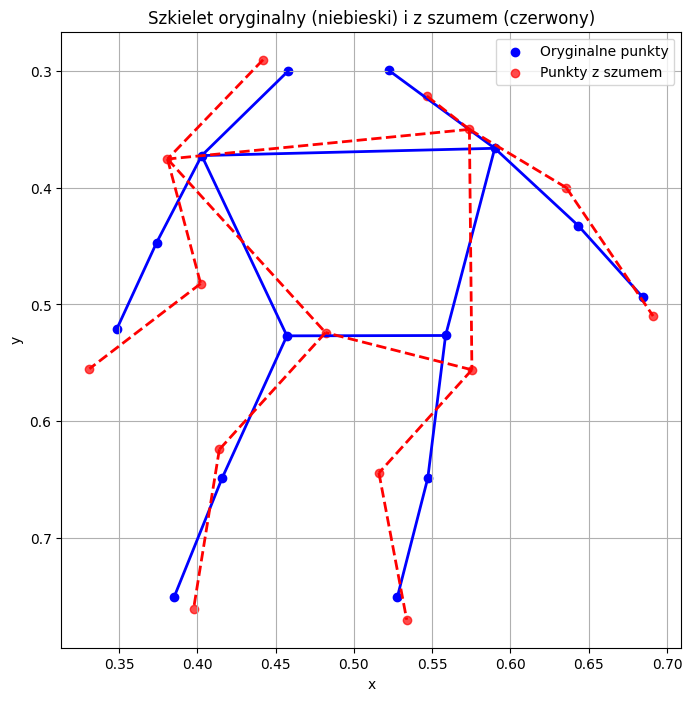

In [335]:
import matplotlib.pyplot as plt

# Załóżmy, że masz points i points_noisy jako listy (x,y)

connections = [
    (0, 2), (2, 4), (4, 6),      # prawa ręka
    (1, 3), (3, 5), (5, 7),      # lewa ręka
    (2, 8), (3, 9),              # barki do bioder
    (8, 10), (10, 12),           # prawa noga
    (9, 11), (11, 13),           # lewa noga
    (2, 3),                      # linia barków
    (8, 9)                       # linia bioder
]

x_orig, y_orig = zip(*points)
x_noisy, y_noisy = zip(*points_noisy)

plt.figure(figsize=(8, 8))

# Rysuj punkty
plt.scatter(x_orig, y_orig, color='blue', label='Oryginalne punkty')
plt.scatter(x_noisy, y_noisy, color='red', label='Punkty z szumem', alpha=0.7)

# Rysuj szkielet dla oryginalnych punktów
for i, j in connections:
    plt.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], 'b-', linewidth=2)

# Rysuj szkielet dla punktów z szumem
for i, j in connections:
    plt.plot([points_noisy[i][0], points_noisy[j][0]], [points_noisy[i][1], points_noisy[j][1]], 'r--', linewidth=2)

plt.title('Szkielet oryginalny (niebieski) i z szumem (czerwony)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


In [336]:
print(procrustes_score(points, points_noisy))
print(pose_angle_score(points, points_noisy))



0.7633583672001393
0.4261203818513455
